# ODE model for GAL switch in yeast
#### nicole pagane | 091918 | roberts lab

In [7]:
import scipy.integrate as snt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
pass

### reactions and parameters
This is a simple model of the GAL switch in yeast.<br>
Terms to add/develop into model:<br>
    G2p (galactose transporter)<br>
    G1p's functionality for signal transduction and only utilize it to metabolize galactose<br>
    ES-complex formation to metabolize galactose<br>
    kinetics of transcription and translation (assumed to be proportional to the effects of upstream regulation)<br>
    RNA Polymerase II elongation rate on a GAL promoter driven gene = 2kb/min


In [11]:
# reactions 
# gal + G3p -> G3p-gal (k1)
# G3p-gal -> gal + G3p (k2)
# G3p-gal + G80p -> G3p-gal-G80p (k3)
# G3p-gal-G80p -> G3p-gal + G80p (k4)
# G80p + UASg -> G80p-UASg (k5)
# G80p-UASg -> G80p + UASg (k6)
# G4p + UASg -> G4p-UASg (k7)
# G4p-UASg -> G4p + UASg (k8)
# G4p-UASg -> G1p + G4p-UASg (k9)
# G4p-UASg -> G3p + G4p-UASg (k10)
# G4p-UASg -> G80p + G4p-UASg (k11)
# G1p + gal -> G1p (k12)

# rate constants
# these rates were taken from (Bianchi 2018)
k1 = 1 
k2 = 1 
k3 = 1 
k4 = 1
k5 = 1
k6 = 1
k7 = 1
k8 = 1
k9 = 1
k10 = 1
k11 = 1
k12 = 1 

# initial concentrations
gal0 = 1e-5
G1p0 = 0.25e-6 # assume to be the same as G3p0 for now
G3p0 = 0.25e-6
G4p0 = 0.005e-6
G80p0 = 0.05e-6
UASg0 = 0 # assume completely repressed
G3pxgal0 = 0 
G3pxgalxG80p0 = 0
G80pxUASg0 = 1e-7 # assume completely repressed
G4pxUASg0 = 0 # assume completely repressed

# species conservation
# UASg = G80p-UASg0 - G80p-UASg - G3p-UASg

# define reaction rates function
#where spec[0] = gal, spec[1] = G1p, spec[2] = G3p, spec[3] = G4p
#      spec[4] = G80p, spec[5] = G3p-gal, spec[6] = G3p-gal-G80p,
#      spec[7] = G80p-UASg, spec[8] = G4p-UASg
def rates(spec, t):
    return np.asarray([
        -kon*spec[0]*(E0 - spec[1] - spec[3]) + koff*spec[1] - kion*spec[1]*spec[0] + kioff*spec[3],   # dS/dt 
        kon*spec[0]*(E0 - spec[1] - spec[3]) - koff*spec[1] - kcat*spec[1] - kion*spec[1]*spec[0] + kioff*spec[3],    # dES/dt
        kcat*spec[1],    # dP/dt
        kion*spec[1]*spec[0] - kioff*spec[3],    # dESS/dt 
    ])


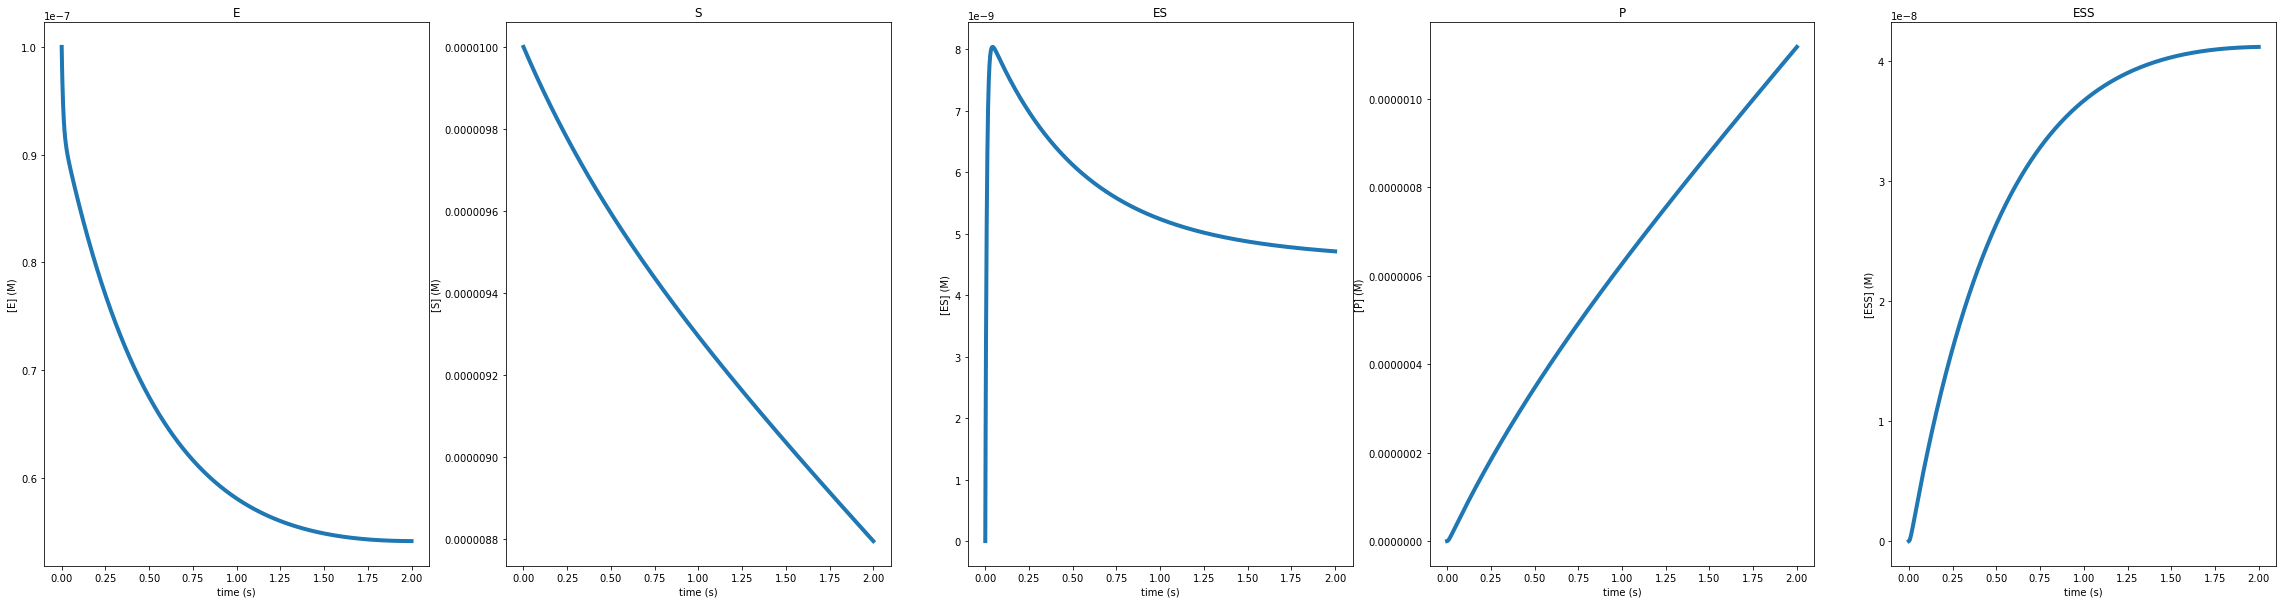

In [14]:
fig = plt.figure(figsize = (40,10))

# solve the DE numerically
t = np.linspace(0,2,1000)
spec0 = (S0, ES0, P0, ESS0)
ode = snt.odeint(rates, spec0, t, hmax=1e-5)

# plot the numerical solution
specs = ['E', 'S', 'ES', 'P', 'ESS']
#plot ligand 
ax = fig.add_subplot(1, np.shape(ode)[1] + 1, 1)
ax.plot(t, E0 - ode[:, 1] - ode[:, 3], linewidth = 4)
ax.set_title(specs[0])
ax.set_ylabel('[' + specs[0] + '] (M)')
ax.set_xlabel('time (s)')
for i in range(np.shape(ode)[1]):
    ax = fig.add_subplot(1, np.shape(ode)[1] + 1, i + 2)
    ax.plot(t, ode[:, i], linewidth = 4)
    ax.set_title(specs[i + 1])
    ax.set_ylabel('[' + specs[i + 1] + '] (M)')
    ax.set_xlabel('time (s)')

plt.show()

In [22]:
# reaction rate dependence on susbstrate concentration simulations
Srange = np.linspace(S0/10, S0*500, 50)
data2 = {}
for i in range(len(Srange)):
    spec0 = (Srange[i], ES0, P0, ESS0)
    ode = snt.odeint(rates, spec0, t, hmax=1e-5)
    data2[Srange[i]] = ode
print 'done'

done


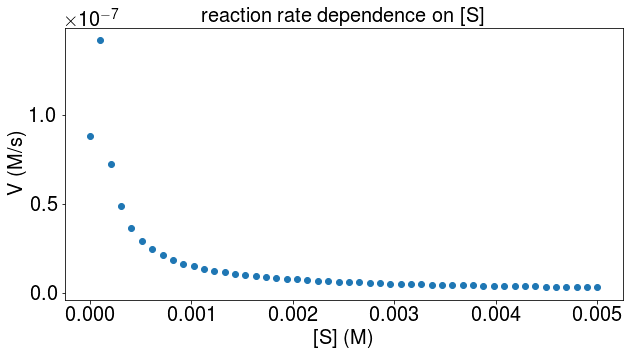

In [23]:
fig = plt.figure(figsize=(10,5))
# plot the data

S = []
V = []
for i in data2:
    dP = np.diff(data2[i][:,2])
    dt = np.diff(t)
    dPdt = np.mean(dP/dt)
    S.append(i)
    V.append(dPdt)

plt.plot(S, V, 'o')
plt.xlabel('[S] (M)')
plt.ylabel('V (M/s)')
plt.title('reaction rate dependence on [S]')

plt.show()